# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")
from utils.s3_utils import download_file



all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


In [4]:
s3_generalisation = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01_negative_generalisation/"
s3_large_scale_high_q = "{}/highquality_sample.json".format(s3_generalisation.rstrip("/"))
s3_large_scale_low_q = "{}/lowquality_sample.json".format(s3_generalisation.rstrip("/"))

## Predictions with markers

In [5]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [6]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [7]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"


def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class = 100, classwise_vocab=True):
    
    max_tree_depth = 4
 
    
   
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier( min_df=min_df, max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0",  min_df=min_df,  max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab, trigger_words=ptm_trigger_words, max_tree_depth = max_tree_depth ),
 #      TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth)

    }
   
    
    result = {}
    
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result



def  predict_all_classifiers(df, models_dict):
    max_words_per_class = 10
    max_tree_depth = 4
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [8]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [9]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


# plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

# plt.show()




In [10]:
from dtreeviz.trees import *

def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)

    plt.show()
    
def plot_tree_pretty(m, x, y, title="", image_save_path=None):
    import sys
    dot_path = '/opt/homebrew/bin/'
    if dot_path not in sys.path :
        sys.path.append( dot_path)
        for p in sys.path:
            os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

    viz = dtreeviz(m.tree_model,
               x_data=m.extract_features(x),
               y_data=y,
               target_name='class',
               feature_names=m.feature_names,
               class_names=label_names,
               title=title)
    
    # tree_plt.view()    
    if image_save_path:
        viz.save(image_save_path)
        
    return viz



In [11]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}
    
    #. ( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])]

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [13]:
def filter_interactions(df, target_column = 'y', target_values=[0, 1]):
    return df[df[target_column].isin(target_values)].copy()

In [14]:
df_train = pd.read_json(trainfile, orient="records").pipe(filter_interactions)
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  116
Training Naive Bayes + Tree
Max words :  116
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      32.3 &   Phosphorylation &   77.0 &     45.5 &     139 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      32.3 &         micro avg &   77.0 &     45.5 &     139 \\
       Naive Bayes &       5.4 &         macro avg &   12.8 &      7.6 &     139 \\
       Naive Bayes &      32.3 &      weighted avg &   77.0 &     45.5 &     139 \\
Naive Bayes + Tree &      72.2 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.965368,Negative,0.799283,0.874510,1116.0
Phosphorylation,Naive Bayes,0.323263,Phosphorylation,0.769784,0.455319,139.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.796016,micro avg,0.796016,0.796016,1255.0
macro avg,Naive Bayes,0.184090,macro avg,0.224152,0.189976,1255.0
weighted avg,Naive Bayes,0.894250,weighted avg,0.796016,0.828082,1255.0


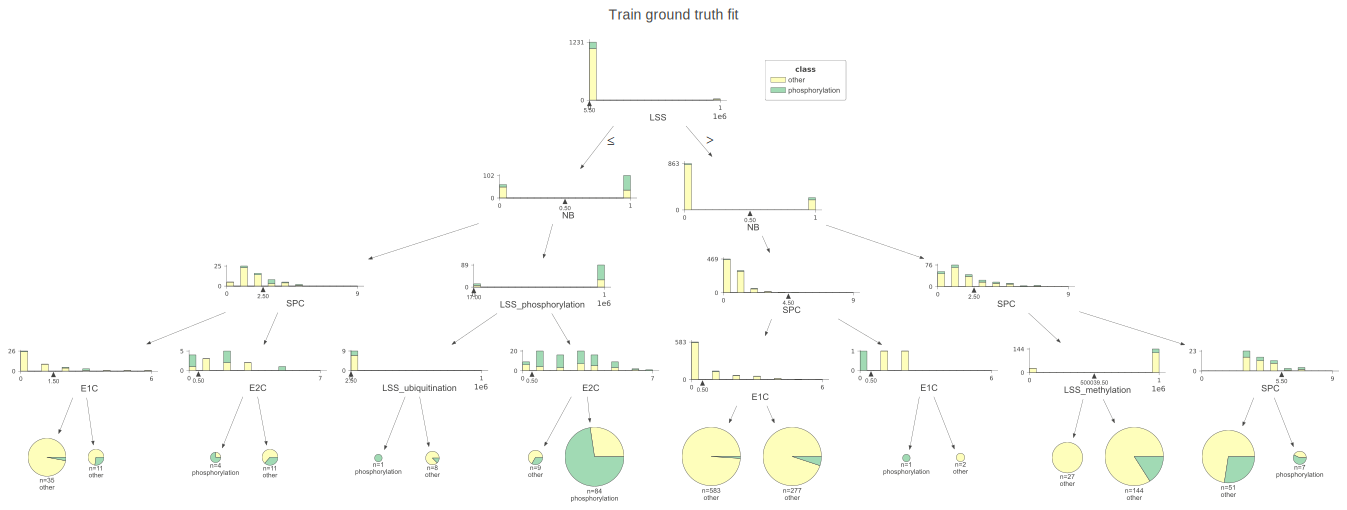

In [15]:
#plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(train_result[NAIVE_BAYES_WITH_TREE]["m"], df_train["x"], df_train["y"], "Train ground truth fit",  "train_gt_fit_tree.svg" )

In [16]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

[('prtig0', -2.6569259084219787),
 ('protpart1', -2.7824459265805146),
 ('protpart0', -2.7878000401252407),
 ('prtig1', -2.8301686994497306),
 ('prtig2', -3.0354608289745677),
 ('prtig3', -3.2098737603085947),
 ('phosphorylation', -3.268105452898803),
 ('cells', -3.7961728830993),
 ('kinase', -3.8288066422926024),
 ('protein', -3.8497571292334056),
 ('prtig4', -3.860399301329551),
 ('activation', -3.8813009631561153),
 ('cell', -4.072547884636389),
 ('induced', -4.281680698881),
 ('tyrosine', -4.317082625931916),
 ('activity', -4.371462708951138),
 ('phosphorylated', -4.444199628378775),
 ('proteins', -4.495358324206327),
 ('signaling', -4.6123005290724),
 ('binding', -4.654005414486861),
 ('kinases', -4.699174382854772),
 ('results', -4.736153386095859),
 ('domain', -4.736153386095859),
 ('dependent', -4.762173934797755),
 ('response', -4.785286074673504),
 ('complex', -4.79613609069757),
 ('expression', -4.79977908197607),
 ('prtig5', -4.812635090077605),
 ('vitro', -4.86577852375331

In [17]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

[('protpart1', -2.124430665818367),
 ('protpart0', -2.2420763482707713),
 ('prtig0', -3.0056300778812517),
 ('phosphorylation', -3.254295497990581),
 ('prtig1', -3.2645519981577698),
 ('kinase', -3.680379893301481),
 ('prtig2', -3.8020768282790005),
 ('cells', -3.850278930096879),
 ('protein', -3.881629459980955),
 ('activation', -4.047526137107509),
 ('cell', -4.047526137107509),
 ('activity', -4.1256909099568455),
 ('phosphorylated', -4.158751772217733),
 ('induced', -4.383998373728722),
 ('tyrosine', -4.460538450851056),
 ('prtig3', -4.507058466485949),
 ('binding', -4.581166438639671),
 ('human', -4.675195388287947),
 ('vitro', -4.703768760732003),
 ('response', -4.748220523302837),
 ('signaling', -4.748220523302837),
 ('domain', -4.763487995433626),
 ('proteins', -4.79474053893773),
 ('kinases', -4.810740880284171),
 ('results', -4.860337821423543),
 ('dna', -4.8774322547828435),
 ('complex', -4.8774322547828435),
 ('expression', -4.894823997494712),
 ('dependent', -4.912523574594

## Val GT predictions


In [18]:
df_val = pd.read_json(valfile, orient="records").pipe(filter_interactions)
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  138
Training Naive Bayes + Tree
Max words :  138
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      28.8 &   Phosphorylation &   71.4 &     41.1 &      21 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      28.8 &         micro avg &   71.4 &     41.1 &      21 \\
       Naive Bayes &       4.8 &         macro avg &   11.9 &      6.8 &      21 \\
       Naive Bayes &      28.8 &      weighted avg &   71.4 &     41.1 &      21 \\
Naive Bayes + Tree &      77.8 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.955556,Negative,0.777108,0.857143,166.0
Phosphorylation,Naive Bayes,0.288462,Phosphorylation,0.714286,0.410959,21.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.770053,micro avg,0.770053,0.770053,187.0
macro avg,Naive Bayes,0.177717,macro avg,0.213056,0.181157,187.0
weighted avg,Naive Bayes,0.880641,weighted avg,0.770053,0.807037,187.0


## Test 

### Predict Test on Test GT fit

In [19]:
df_test = pd.read_json(testfile, orient="records").pipe(filter_interactions)
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  141
Training Naive Bayes + Tree
Max words :  141
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      26.7 &   Phosphorylation &   88.6 &     41.1 &      44 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      26.7 &         micro avg &   88.6 &     41.1 &      44 \\
       Naive Bayes &       4.5 &         macro avg &   14.8 &      6.8 &      44 \\
       Naive Bayes &      26.7 &      weighted avg &   88.6 &     41.1 &      44 \\
Naive Bayes + Tree &      65.0 &   

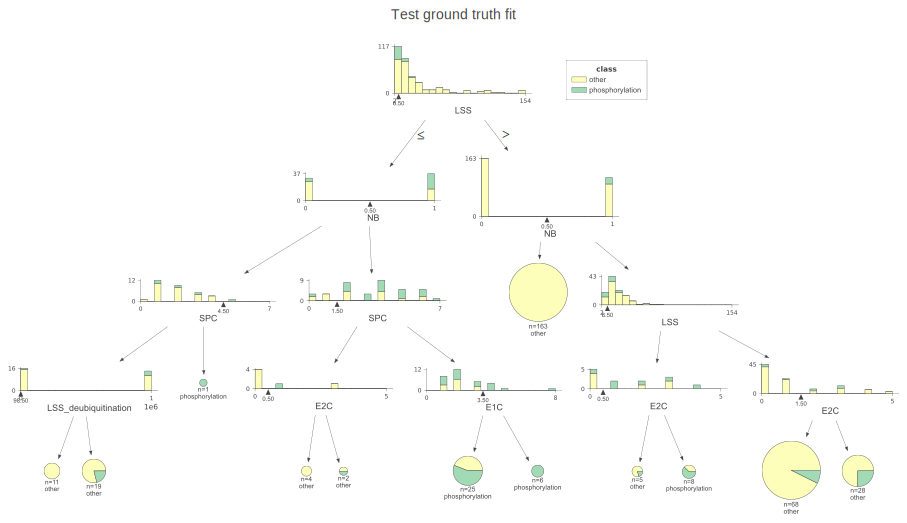

In [20]:
#plot_tree(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"], df_test["x"], df_test["y"],"Test ground truth fit", "test_gt_fit_tree.svg")

### Test on train fit

In [21]:
result_train_predict_test_gt = predict_all_classifiers(df_test, result_test_gt)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      97.4 &          Negative &   63.9 &     77.1 &     296 \\
       Naive Bayes &      26.7 &   Phosphorylation &   88.6 &     41.1 &      44 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      67.1 &         micro avg &   67.1 &     67.1 &     340 \\
       Naive Bayes &      17.7 &         macro avg &   21.8 &     16.9 &     340 \\
       Naive Bayes &      88.3 &      weighted avg &   67.1 &     72.5 &     340 \\
Naive Bayes + Tree &      94.0 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.974227,Negative,0.638514,0.771429,296.0
Phosphorylation,Naive Bayes,0.267123,Phosphorylation,0.886364,0.410526,44.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.670588,micro avg,0.670588,0.670588,340.0
macro avg,Naive Bayes,0.177336,macro avg,0.217840,0.168851,340.0
weighted avg,Naive Bayes,0.882719,weighted avg,0.670588,0.724724,340.0


### Predict Test on Test Prediction fit 

In [22]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file).pipe(filter_interactions, 'class', ['phosphorylation', 'other'])

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


Training Naive Bayes
Max words :  250
Training Naive Bayes + Tree
Max words :  250
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      21.3 &   Phosphorylation &   95.0 &     34.9 &      20 \\
       Naive Bayes &      10.0 & Dephosphorylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &      33.3 &       Methylation &  100.0 &     50.0 &       3 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      21.3 &         micro avg &   95.8 &     34.8 &      24 \\
       Naive Bayes &      10.8 &         macro avg &   49.2 &     17.2 &      24 \\
       Naive Bayes &      22.4 &      weighted avg &   95.8 &     36.1 &      24 \\
Naive Bayes + Tree &      83.3 &   

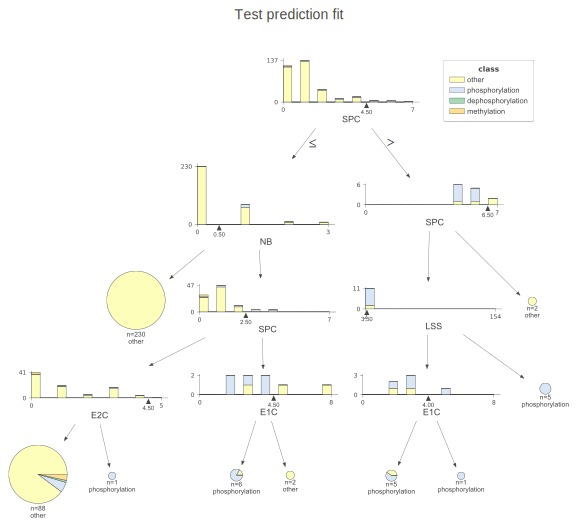

In [23]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
plot_tree_pretty(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], df_test_prediction["x"], df_test_prediction["y"], "Test prediction fit", "test_prediction_treeplot.svg")

In [24]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrlrrrrrrr}
\toprule
             model &  precision\_x &             index &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
       Naive Bayes &        21.3 &   Phosphorylation &     95.0 &       34.9 &    2000.0 &        26.7 &     88.6 &       41.1 &    4400.0 \\
       Naive Bayes &        10.0 & Dephosphorylation &    100.0 &       18.2 &     100.0 &         0.0 &      0.0 &        0.0 &       0.0 \\
       Naive Bayes &        33.3 &       Methylation &    100.0 &       50.0 &     300.0 &         0.0 &      0.0 &        0.0 &       0.0 \\
       Naive Bayes &         0.0 &    Ubiquitination &      0.0 &        0.0 &       0.0 &         0.0 &      0.0 &        0.0 &       0.0 \\
       Naive Bayes &         0.0 &       Acetylation &      0.0 &        0.0 &       0.0 &         0.0 &      0.0 &        0.0 &       0.0 \\
       Naive Bayes &         0.0 &  Deubiquitination &      0.0 &        0.0 &       0

### Test prediction on train fit

In [25]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, result_test_bp)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   73.1 &     84.3 &     316 \\
       Naive Bayes &      21.3 &   Phosphorylation &   95.0 &     34.9 &      20 \\
       Naive Bayes &      10.0 & Dephosphorylation &  100.0 &     18.2 &       1 \\
       Naive Bayes &      33.3 &       Methylation &  100.0 &     50.0 &       3 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      74.7 &         micro avg &   74.7 &     74.7 &     340 \\
       Naive Bayes &      23.5 &         macro avg &   52.6 &     26.8 &     340 \\
       Naive Bayes &      94.1 &      weighted avg &   74.7 &     80.9 &     340 \\
Naive Bayes + Tree &      97.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.995690,Negative,0.731013,0.843066,316.0
Phosphorylation,Naive Bayes,0.213483,Phosphorylation,0.950000,0.348624,20.0
Dephosphorylation,Naive Bayes,0.100000,Dephosphorylation,1.000000,0.181818,1.0
Methylation,Naive Bayes,0.333333,Methylation,1.000000,0.500000,3.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.747059,micro avg,0.747059,0.747059,340.0
macro avg,Naive Bayes,0.234644,macro avg,0.525859,0.267644,340.0
weighted avg,Naive Bayes,0.941199,weighted avg,0.747059,0.809009,340.0


## Fit large scale Negative high quality

In [26]:

local_hq_file= os.path.join(temp_dir, s3_large_scale_high_q.split("/")[-1])

download_file(s3_large_scale_high_q , temp_dir)

t = load_large_scale(local_hq_file)


df_largescale_negative_sample_hq = pd.concat([t.query("y==0").sample(n=5000, random_state=43),
                                              t.query("y==1").sample(n=250, random_state=43)])


result_largescale_negative_sample_hq  = train_and_predict_all_classifiers(df_largescale_negative_sample_hq)



print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)





Training Naive Bayes
Max words :  133
Training Naive Bayes + Tree
Max words :  133
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      63.2 &   Phosphorylation &   94.0 &     75.6 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      63.2 &         micro avg &   94.0 &     75.6 &     250 \\
       Naive Bayes &      10.5 &         macro avg &   15.7 &     12.6 &     250 \\
       Naive Bayes &      63.2 &      weighted avg &   94.0 &     75.6 &     250 \\
Naive Bayes + Tree &      84.8 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.996925,Negative,0.972600,0.984612,5000.0
Phosphorylation,Naive Bayes,0.631720,Phosphorylation,0.940000,0.755627,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.971048,micro avg,0.971048,0.971048,5250.0
macro avg,Naive Bayes,0.232664,macro avg,0.273229,0.248606,5250.0
weighted avg,Naive Bayes,0.979534,weighted avg,0.971048,0.973708,5250.0


In [27]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"],0)

[('prtig0', -2.641334609566096),
 ('prtig1', -2.82190409083732),
 ('cells', -2.964174087343828),
 ('protpart1', -3.105915511776095),
 ('prtig2', -3.1131692207925656),
 ('protpart0', -3.116815902305415),
 ('cell', -3.449681903125528),
 ('prtig3', -3.4874766798421835),
 ('expression', -3.7259159759144733),
 ('prtig4', -3.8362858035510783),
 ('human', -4.160250629547537),
 ('prtig5', -4.256656194431555),
 ('protein', -4.349684715241209),
 ('gene', -4.463124827368763),
 ('induced', -4.531310135564309),
 ('growth', -4.531727759291406),
 ('prtig6', -4.559683836557996),
 ('proteins', -4.668007883852758),
 ('activity', -4.669445009848606),
 ('mrna', -4.6996176150019675),
 ('binding', -4.729201121105962),
 ('levels', -4.740460196031884),
 ('prtig7', -4.863532542865124),
 ('factor', -4.881148970253421),
 ('effect', -4.884115451218518),
 ('results', -4.89486824299478),
 ('expressed', -4.908169527372056),
 ('genes', -4.90999712459108),
 ('activation', -4.944740073034953),
 ('anti', -4.951708742351

In [28]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"] ,1)

[('protpart1', -2.1623131055538503),
 ('protpart0', -2.17370924028472),
 ('phosphorylation', -2.9068032810555176),
 ('protein', -3.1185802657126622),
 ('kinase', -3.2468604647545565),
 ('cells', -3.3843902633457743),
 ('activity', -3.7521150434710915),
 ('phosphorylated', -3.7802859204377883),
 ('cell', -3.901646777442055),
 ('prtig0', -4.267581046793585),
 ('tyrosine', -4.348269958043727),
 ('proteins', -4.445262224031037),
 ('dependent', -4.522223265167165),
 ('human', -4.552682472651874),
 ('activation', -4.5947939580020005),
 ('binding', -4.5947939580020005),
 ('vitro', -4.616533944638407),
 ('results', -4.616533944638407),
 ('purified', -4.7206742038910035),
 ('specific', -4.809905337618947),
 ('stimulated', -4.823328357951087),
 ('increase', -4.90788574597915),
 ('increased', -4.937738709128832),
 ('induced', -4.937738709128832),
 ('receptor', -4.95300618125962),
 ('factor', -4.968510367795585),
 ('growth', -5.0165195869819454),
 ('muscle', -5.0165195869819454),
 ('site', -5.0165

### Fit to train

In [29]:
result_train_predict_largescale_negative_sample_hq = predict_all_classifiers(df_largescale_negative_sample_hq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq, all_labels)

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   93.8 &     96.6 &    5000 \\
       Naive Bayes &      42.9 &   Phosphorylation &   93.2 &     58.8 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      93.8 &         micro avg &   93.8 &     93.8 &    5250 \\
       Naive Bayes &      20.4 &         macro avg &   26.7 &     22.2 &    5250 \\
       Naive Bayes &      96.9 &      weighted avg &   93.8 &     94.8 &    5250 \\
Naive Bayes + Tree &      96.1 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.996388,Negative,0.938000,0.966313,5000.0
Phosphorylation,Naive Bayes,0.429098,Phosphorylation,0.932000,0.587642,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.937714,micro avg,0.937714,0.937714,5250.0
macro avg,Naive Bayes,0.203641,macro avg,0.267143,0.221994,5250.0
weighted avg,Naive Bayes,0.969375,weighted avg,0.937714,0.948281,5250.0


In [30]:
plot_tree_pretty(result_largescale_negative_sample_hq[NAIVE_BAYES_WITH_TREE]["m"], df_largescale_negative_sample_hq["x"], df_largescale_negative_sample_hq["y"],"Generalization high confidence predictions fit", "largescale_hq_treeplot.svg")

Exception: darwin can only save .svg files: largescale_hq_treeplot.png

## Fit large scale Negative low quality

In [ ]:
local_lq_file= os.path.join(temp_dir, s3_large_scale_low_q.split("/")[-1])

download_file(s3_large_scale_low_q , temp_dir)



df_largescale_negative_sample_lq = load_large_scale(local_lq_file)
df_largescale_negative_sample_lq = pd.concat([df_largescale_negative_sample_lq.query("y==0").sample(n=5000, random_state=43),
                                              df_largescale_negative_sample_lq.query("y==1").sample(n=250, random_state=43 )])


result_largescale_negative_sample_lq  = train_and_predict_all_classifiers(df_largescale_negative_sample_lq)



print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)






In [ ]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],0)

In [ ]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],1)

### Fit to train

In [ ]:


result_train_predict_largescale_negative_sample_low_q = predict_all_classifiers(df_largescale_negative_sample_lq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q, all_labels)


In [ ]:
import numpy as np
import math
from scipy.spatial import distance



def _build_list(l1,l2, use_common_only=True):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
           
    if use_common_only:
        intersection = set([w for w,_ in l2]).intersection(set([w for w,_ in l1]))
        word_index = {w:i for i,w in enumerate(intersection)}


    
    l1_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l1)):        
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l2)):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r

def js_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return distance.jensenshannon(p,q, 2.71828)



def compute_js_divergence(p1_model_result, p2_model_result, label_names=renamed_labels[:2], use_common_only=False):
    result = []
    for i, l in enumerate(label_names):
        p = js_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i),
                          use_common_only=use_common_only
                     )
        result.append({
            "label_name" : l,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)

def plot_divergence(df1,t1, df2, t2, ax, suffix_y_label):
    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.4
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"], rotation = 45)
    
    ax.set_ylim(0,1)
    
    ax.set_ylabel(f"JS divergence {suffix_y_label}")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')



_, axes= plt.subplots(1,3, figsize=(15,5))  


classifiers = {NAIVE_BAYES}

kwargs = {
    "ngram_range":(1,1),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  5000
}



ax = axes[0]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 1")

ax.legend().remove()

kwargs = {
    "ngram_range":(2,2),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  5000
}



ax = axes[1]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 2")

ax.legend().remove()




kwargs = {
    "ngram_range":(3,3),
   "min_df": 5,
   "stop_words":'english',
    "classifiers":classifiers,
    "max_words_per_class" :  5000,
    "classwise_vocab":False
}

ax = axes[2]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 3")

ax.legend().remove()



## Latex results

In [ ]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)
df_summ_negative_sample_lq = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)

df_summ_negative_sample_hq = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)




df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_lq, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_hq, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]}




                ],


              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)
df_summ_trainfit_large_high = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq,  all_labels)
df_summ_trainfit_large_low = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Negative"]
              )

print("**Negative***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Phosphorylation"]
              )

print("**Phosphorylation***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

In [ ]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ


df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))